# Ablation Study

### Default model performance

Let's see how the model with defualt parameters performs on the 'hard' (unperfect_200) and 'easy (perfect_200) datasets

##### Easy test set
![Defualt Model on perfect dataset](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180_perfect_200.png)
![Defualt Model on perfect dataset (misclassified)](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180_perfect_200_misclassified.png)

##### Hard test set
![Defualt Model on perfect dataset](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180_unperfect_200.png)
![Defualt Model on perfect dataset (misclassified)](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c8_b16_n9_s1_default_180_unperfect_200_misclassified.png)

As previously doccumented, we will use the 'hard' test set (unperfect_200) for the ablation study to to amplify variance between models. We use the easier dataset to crosscheck that the model still performs well on easy testing images

### Setup functions for Ablation

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import time
import joblib
import io
from pathlib import Path
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve, auc, det_curve
from contextlib import redirect_stdout


script_path = os.path.abspath('../Submission/Others/Scripts')
print(script_path)

# Add this path to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

# Now you can import the modules
from extract_HOG import compute_hog, is_image_file, test_final_dataset
from train_SVM import ProgressMonitorCallback
from evaluate_final_model import evaluate_final_model

# Constants - Paths
# Make sure we get the correct base path by starting from this script's location
BASE_PATH = Path(os.getcwd()).resolve().parent
print(f"Project root path: {BASE_PATH}")

NOTEBOOKS_DIR = BASE_PATH / "notebooks"
OUTPUTS_DIR = NOTEBOOKS_DIR / "outputs"
DATASETS_DIR = BASE_PATH / "Datasets"
TRAIN_DIR = DATASETS_DIR / "Train"
TEST_DIR = DATASETS_DIR / "Test"
FEATURE_DIR = BASE_PATH / "Features"
MODEL_DIR = BASE_PATH  / "Models"
RESULTS_DIR = BASE_PATH / "notebooks" / "outputs"

# Print paths to verify
print(f"Notebooks directory: {NOTEBOOKS_DIR}")
print(f"Outputs directory: {OUTPUTS_DIR}")
print(f"Datasets directory: {DATASETS_DIR}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Features directory: {FEATURE_DIR}")
print(f"Models directory: {MODEL_DIR}")

# Create directories if they don't exist
FEATURE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Constants - Dataset names
TRAIN_DATASET = "PETA_INRIA_h250p_nh250pp"
TEST_DATASET = "unperfect_200" # use hard dataset for final testing to amplify variance between models

# Check if training dataset exists
train_dataset_path = TRAIN_DIR / TRAIN_DATASET
if not train_dataset_path.exists():
    print(f"WARNING: Training dataset '{TRAIN_DATASET}' not found at {train_dataset_path}")
    print("Available training datasets:")
    for dir in TRAIN_DIR.glob("*"):
        if dir.is_dir():
            print(f"  - {dir.name}")

# Check if test dataset exists
test_dataset_path = TEST_DIR / TEST_DATASET
if not test_dataset_path.exists():
    print(f"WARNING: Test dataset '{TEST_DATASET}' not found at {test_dataset_path}")
    print("Available test datasets:")
    for dir in TEST_DIR.glob("*"):
        if dir.is_dir():
            print(f"  - {dir.name}")

# SVM parameters
C_VALUE = 1.0
MAX_ITER = 10000
RANDOM_SEED = 4402

/Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Submission/Others/Scripts
Project root path: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection
Notebooks directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/notebooks
Outputs directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/notebooks/outputs
Datasets directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets
Train directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Train
Test directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Test
Features directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Features
Models directory: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Rese

Lets define the functions we will use to build and test different models with different parameters

In [5]:
def is_image_file_ext(file_path):
    """Check if a file has an image extension"""
    extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.gif']
    return str(file_path).lower().endswith(tuple(extensions))

def load_and_extract_hog_features(source_dir, cell_size, block_size, num_bins, block_stride, angle=180):
    """Extract HOG features from all images in the specified directory"""
    print(f"Extracting HOG features: cell={cell_size}, block={block_size}, bins={num_bins}, stride={block_stride}, angle={angle}")
    
    # Get all image paths from the human and non-human folders
    human_dir = source_dir / "human_train"
    non_human_dir = source_dir / "non_human_train"
    
    # Debug: Print exact paths to check if they exist
    print(f"Looking for human images in: {human_dir}")
    print(f"Looking for non-human images in: {non_human_dir}")
    print(f"Human directory exists: {human_dir.exists()}")
    print(f"Non-human directory exists: {non_human_dir.exists()}")
    
    # Use both the imported is_image_file function and our extension check
    human_images = []
    if human_dir.exists():
        human_images = [f for f in human_dir.glob("*") if is_image_file_ext(f)]
        if not human_images:
            print("No image files found by extension check in human directory")
            # Try the imported function as backup
            human_images = [f for f in human_dir.glob("*") if is_image_file(f)]
            print(f"  After using is_image_file function: {len(human_images)} files found")
    else:
        print(f"Human directory {human_dir} does not exist!")
        
    non_human_images = []
    if non_human_dir.exists():
        non_human_images = [f for f in non_human_dir.glob("*") if is_image_file_ext(f)]
        if not non_human_images:
            print("No image files found by extension check in non-human directory")
            # Try the imported function as backup
            non_human_images = [f for f in non_human_dir.glob("*") if is_image_file(f)]
            print(f"  After using is_image_file function: {len(non_human_images)} files found")
    else:
        print(f"Non-human directory {non_human_dir} does not exist!")
    
    print(f"Found {len(human_images)} human images and {len(non_human_images)} non-human images")
    
    # Process human images
    human_features = []
    for i, img_path in enumerate(human_images):
        if i > 0 and i % 50 == 0:
            print(f"  Processed {i}/{len(human_images)} human images")
        
        # Read and convert image to grayscale
        img = plt.imread(str(img_path))
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        # Convert to grayscale if the image is RGB
        if len(img.shape) > 2:
            # Handle different image formats (PNG has 0-1 range, JPG has 0-255)
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            gray = np.mean(img, axis=2).astype(np.uint8)
        else:
            gray = img.astype(np.uint8)
            
        # Extract HOG features
        hog_features = compute_hog(gray, cell_size=cell_size, block_size=block_size, 
                                  num_bins=num_bins, block_stride=block_stride, angle=angle)
        if hog_features.size > 0:
            human_features.append(hog_features)
    
    # Process non-human images
    non_human_features = []
    for i, img_path in enumerate(non_human_images):
        if i > 0 and i % 50 == 0:
            print(f"  Processed {i}/{len(non_human_images)} non-human images")
        
        # Read and convert image to grayscale
        img = plt.imread(str(img_path))
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        # Convert to grayscale if the image is RGB
        if len(img.shape) > 2:
            # Handle different image formats (PNG has 0-1 range, JPG has 0-255)
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            gray = np.mean(img, axis=2).astype(np.uint8)
        else:
            gray = img.astype(np.uint8)
            
        # Extract HOG features
        hog_features = compute_hog(gray, cell_size=cell_size, block_size=block_size, 
                                  num_bins=num_bins, block_stride=block_stride, angle=angle)
        if hog_features.size > 0:
            non_human_features.append(hog_features)
    
    print(f"Extracted features for {len(human_features)} human and {len(non_human_features)} non-human images")
    
    # Create feature matrices and labels
    human_features = np.array(human_features)
    non_human_features = np.array(non_human_features)
    
    if len(human_features) == 0 or len(non_human_features) == 0:
        print("Error: Failed to extract features for at least one class")
        return None, None
    
    # Verify feature dimensionality match
    if human_features.shape[1] != non_human_features.shape[1]:
        print(f"Error: Feature dimensions don't match! Human: {human_features.shape[1]}, Non-human: {non_human_features.shape[1]}")
        return None, None
    
    # Combine features and create labels
    X = np.vstack((human_features, non_human_features))
    y = np.concatenate((np.ones(len(human_features)), np.zeros(len(non_human_features))))
    
    print(f"Final feature matrix shape: {X.shape}")
    return X, y

def train_svm_model(X, y, C=1.0, max_iter=10000, seed=RANDOM_SEED):
    """Train an SVM model with the given features and labels"""
    print(f"Training SVM model (C={C}, max_iter={max_iter})...")
    
    # Create progress monitor
    progress_monitor = ProgressMonitorCallback(max_iter)
    
    # Initialize and train SVM
    start_time = time.time()
    svm_classifier = LinearSVC(
        C=C,
        max_iter=max_iter,
        random_state=seed,
        verbose=0
    )
    
    # Train the model
    svm_classifier.fit(X, y)
    
    end_time = time.time()
    train_time = end_time - start_time
    
    print(f"\nTraining completed in {train_time:.2f} seconds")
    train_accuracy = svm_classifier.score(X, y)
    print(f"Training accuracy: {train_accuracy:.4f}")
    
    return svm_classifier

def evaluate_ablation_model(model_path, test_dataset_name, hog_params):
    """
    Custom evaluation function that uses the updated evaluate_final_model
    but returns prediction results for analysis
    """
    # Create test data paths
    test_dir = TEST_DIR / test_dataset_name
    human_test_dir = test_dir / "human_test"
    non_human_test_dir = test_dir / "non_human_test"
    
    if not human_test_dir.exists() or not non_human_test_dir.exists():
        print(f"Error: Test directories not found at {human_test_dir} or {non_human_test_dir}")
        return None
    
    # Load the model
    try:
        print(f"Loading model from: {model_path}")
        svm_classifier = joblib.load(model_path)
        print("Model loaded successfully")
    except Exception as e:
        print(f"Failed to load model: {e}")
        return None
    
    y_true = []
    y_scores = []  # Store decision values
    
    # Process positive samples (humans)
    print("Processing human test images...")
    for img_name in os.listdir(human_test_dir):
        img_path = os.path.join(human_test_dir, img_name)
        if img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Extract HOG features
            hog_features = compute_hog(gray, 
                                     cell_size=hog_params.get('cell_size', 8),
                                     block_size=hog_params.get('block_size', 16),
                                     num_bins=hog_params.get('num_bins', 9),
                                     block_stride=hog_params.get('block_stride', 1),
                                     angle=hog_params.get('angle', 180))
            
            # Get decision value (distance to hyperplane)
            decision_value = svm_classifier.decision_function(hog_features.reshape(1, -1))[0]
            
            y_true.append(1)  # 1 = human
            y_scores.append(decision_value)
    
    # Process negative samples (non-humans)
    print("Processing non-human test images...")
    for img_name in os.listdir(non_human_test_dir):
        img_path = os.path.join(non_human_test_dir, img_name)
        if img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Extract HOG features
            hog_features = compute_hog(gray, 
                                     cell_size=hog_params.get('cell_size', 8),
                                     block_size=hog_params.get('block_size', 16),
                                     num_bins=hog_params.get('num_bins', 9),
                                     block_stride=hog_params.get('block_stride', 1),
                                     angle=hog_params.get('angle', 180))
            
            # Get decision value (distance to hyperplane)
            decision_value = svm_classifier.decision_function(hog_features.reshape(1, -1))[0]
            
            y_true.append(0)  # 0 = non-human
            y_scores.append(decision_value)
    
    if not y_true:
        print("No valid predictions were made.")
        return None
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    return y_true, y_scores

def evaluate_and_save_results(model_suffix, hog_params, results_file):
    """Evaluate the model on the test dataset and save results"""
    # Get model path
    model_path = MODEL_DIR / f"svm_hog_classifier{model_suffix}.joblib"
    
    if not model_path.exists():
        print(f"Error: Model not found at {model_path}")
        return None
    
    # Evaluate model using our custom evaluation function
    result = evaluate_ablation_model(model_path, TEST_DATASET, hog_params)
    
    if result is None:
        print("Evaluation failed")
        return None
        
    y_true, y_scores = result
    
    if y_true is not None and len(y_true) > 0:
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Calculate DET curve
        fpr_det, fnr_det, _ = det_curve(y_true, y_scores)
        
        # Calculate accuracy using default threshold (0)
        y_pred = (y_scores > 0).astype(int)
        accuracy = np.mean(y_true == y_pred)
        
        # Calculate TP, TN, FP, FN
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        # Record results
        results = {
            "model_suffix": model_suffix,
            "hog_params": hog_params,
            "accuracy": accuracy,
            "auc": roc_auc,
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "fpr_det": fpr_det.tolist(),
            "fnr_det": fnr_det.tolist()
        }
        
        # Save results to file
        if results_file.exists():
            try:
                all_results = np.load(results_file, allow_pickle=True)
                all_results = all_results.tolist()
                all_results.append(results)
            except:
                all_results = [results]
        else:
            all_results = [results]
        
        np.save(results_file, all_results, allow_pickle=True)
        print(f"Results saved to {results_file}")
        
        return results
    else:
        print("No valid predictions, skipping evaluation")
        return None

In [6]:
def run_experiment(cell_size, block_size, num_bins, block_stride, angle):
    """Run a complete experiment with the given HOG parameters"""
    # Create parameter suffix for naming - remove "_default" since we're using specific parameters
    param_suffix = f"_c{cell_size}_b{block_size}_n{num_bins}_s{block_stride}_{angle}"
    model_suffix = f"_{TRAIN_DATASET}{param_suffix}"
    feature_suffix = f"_{TRAIN_DATASET}{param_suffix}"
    
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: Cell={cell_size}, Block={block_size}, Bins={num_bins}, Stride={block_stride}, Angle={angle}")
    print(f"{'='*80}")
    
    # Create HOG parameters dictionary
    hog_params = {
        'cell_size': cell_size,
        'block_size': block_size,
        'num_bins': num_bins,
        'block_stride': block_stride,
        'angle': angle
    }
    
    # Check if features already exist
    x_feature_file = FEATURE_DIR / f"X_train{feature_suffix}.npy"
    y_feature_file = FEATURE_DIR / f"y_train{feature_suffix}.npy"
    
    # Check if model already exists
    model_file = MODEL_DIR / f"svm_hog_classifier{model_suffix}.joblib"
    
    # 1. Extract HOG features or load existing ones
    if x_feature_file.exists() and y_feature_file.exists():
        print(f"Loading existing features from {x_feature_file}")
        X = np.load(x_feature_file)
        y = np.load(y_feature_file)
        print(f"Loaded features: X shape={X.shape}, y shape={y.shape}")
    else:
        print("Extracting HOG features...")
        X, y = load_and_extract_hog_features(
            TRAIN_DIR / TRAIN_DATASET,
            cell_size, block_size, num_bins, block_stride, angle
        )
        
        if X is not None and y is not None:
            # Save features
            np.save(x_feature_file, X)
            np.save(y_feature_file, y)
            print(f"Saved features to {x_feature_file} and {y_feature_file}")
        else:
            print("Feature extraction failed, skipping this configuration")
            return None
    
    # 2. Train SVM model or load existing one
    if model_file.exists():
        print(f"Loading existing model from {model_file}")
        svm_classifier = joblib.load(model_file)
    else:
        print("Training SVM model...")
        svm_classifier = train_svm_model(X, y, C=C_VALUE, max_iter=MAX_ITER)
        
        # Save model
        joblib.dump(svm_classifier, model_file)
        print(f"Saved model to {model_file}")
    
    # 3. Evaluate model
    print("Evaluating model on test dataset...")
    results_file = RESULTS_DIR / f"ablation_results.npy"

    
    # Create a string buffer to capture output
    f = io.StringIO()
    with redirect_stdout(f):
        results = evaluate_and_save_results(model_suffix, hog_params, results_file)
    
    return results



In [7]:
def run_cell_block_experiments():
    """Run experiments for different cell/block size combinations"""
    print("\n=== CELL/BLOCK SIZE EXPERIMENTS ===")
    results = []
    
    # Import required modules for evaluation
    import cv2
    
    for i, (cell_size, block_size) in enumerate(CELL_BLOCK_LIST, 1):
        print(f"\nExperiment {i}/{len(CELL_BLOCK_LIST)}: Cell={cell_size}, Block={block_size}")
        
        # Use default values for other parameters
        result = run_experiment(cell_size, block_size, num_bins=9, block_stride=1, angle=180)
        if result:
            results.append(result)
    
    # Return all results for this experiment type
    return results

### Ablation 1: Cell block size

In [8]:
CELL_BLOCK_LIST = [(2,4), (2,6), (2,8), (2,16), (4,8), (4,16), (4,32), (8,16), (8,32), (16,32)]

# Import cv2 here so it's available for all functions
import cv2

results_cell_block = run_cell_block_experiments()


=== CELL/BLOCK SIZE EXPERIMENTS ===

Experiment 1/10: Cell=2, Block=4

EXPERIMENT: Cell=2, Block=4, Bins=9, Stride=1, Angle=180
Extracting HOG features...
Extracting HOG features: cell=2, block=4, bins=9, stride=1, angle=180
Looking for human images in: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Train/PETA_INRIA_h250p_nh250pp/human_train
Looking for non-human images in: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Train/PETA_INRIA_h250p_nh250pp/non_human_train
Human directory exists: True
Non-human directory exists: True
Found 250 human images and 250 non-human images
  Processed 50/250 human images
  Processed 100/250 human images
  Processed 150/250 human images
  Processed 200/250 human images
  Processed 50/250 non-human images
  Processed 100/250 non-human images
  Processed 150/250 non-human images
  Processed 200/250 non-human images
Extracted features for 250 human and 250 n

In [9]:
def plot_roc_det_curves(results, title_prefix="Performance", param_format=None, ablation_type="cell_block"):
    """
    Plot ROC and DET curves for a set of results.
    
    Args:
        results: List of result dictionaries
        title_prefix: Prefix for plot titles
        param_format: Optional function to format parameter labels
        ablation_type: Type of ablation study ("cell_block" or "bin_angle")
    """
    # Sort results by AUC (best first)
    sorted_results = sorted(results, key=lambda x: x['auc'], reverse=True)
    
    # Create ablation results list
    ablation_results = []
    
    # Create figure with two subplots
    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(14, 6))
    
    for result in sorted_results:
        params = result["hog_params"]
        
        # Calculate accuracy
        tp = result["tp"]
        tn = result["tn"]
        fp = result["fp"]
        fn = result["fn"]
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        # Add to ablation results based on ablation type
        if ablation_type == "cell_block":
            ablation_results.append({
                'model': f"C{params['cell_size']}/B{params['block_size']}",
                'auc': result['auc'],
                'accuracy': accuracy
            })
        elif ablation_type == "bin_angle":
            ablation_results.append({
                'model': f"Bins{params['num_bins']}/Angle{params['angle']}",
                'auc': result['auc'],
                'accuracy': accuracy
            })
        
        # Generate label based on provided format function or parameter keys
        if param_format:
            label = param_format(params, result['auc'], accuracy)
        else:
            # Default formatting based on ablation type
            if ablation_type == "cell_block":
                label = f"C{params['cell_size']}/B{params['block_size']} (AUC={result['auc']:.4f}, Acc={accuracy:.4f})"
            else:
                label = f"Bin{params['num_bins']}/Ang{params['angle']} (AUC={result['auc']:.4f}, Acc={accuracy:.4f})"
        
        # Plot ROC curve
        ax_roc.plot(result["fpr"], result["tpr"], label=label)
        
        # Plot DET curve
        if "fpr_det" in result and "fnr_det" in result:
            ax_det.plot(result["fpr_det"], result["fnr_det"], label=label)
        else:
            # If DET curve data is not available, calculate it
            fpr_det, fnr_det, _ = det_curve(np.array([1 if x == 1 else 0 for x in result["y_true"]]) if "y_true" in result else [1, 0], 
                                          np.array(result["y_scores"]) if "y_scores" in result else [1, 0])
            fpr_det = np.clip(fpr_det, 1e-6, None)
            ax_det.plot(fpr_det, fnr_det, label=label)
    
    # Format ROC plot
    ax_roc.set_title(f"ROC Curve - {title_prefix}")
    ax_roc.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.grid(True, linestyle='--')
    ax_roc.legend(fontsize=6, loc='lower right')
    
    # Format DET plot
    ax_det.set_title(f"DET Curve - {title_prefix}")
    ax_det.set_xscale('log')
    ax_det.set_xlabel('False Positive Rate (log scale)')
    ax_det.set_ylabel('False Negative Rate')
    ax_det.set_ylim(0, 0.5)
    ax_det.set_xlim([1e-4, 1e0])
    ax_det.grid(True, linestyle='--')
    ax_det.legend(fontsize=6, loc='upper right')
    
    plt.tight_layout()
    return fig, ax_roc, ax_det, ablation_results

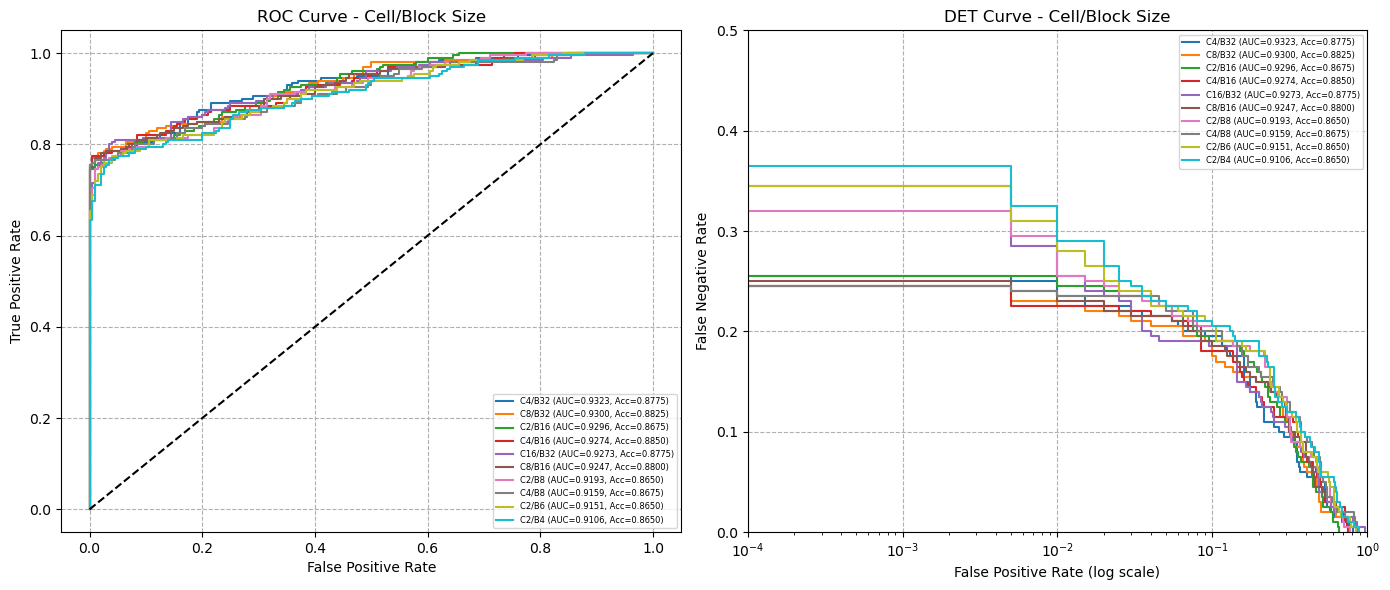

In [10]:
if results_cell_block:
    fig, ax_roc, ax_det, ablation_results = plot_roc_det_curves(
        results_cell_block, 
        title_prefix="Cell/Block Size",
        param_format=lambda params, auc, accuracy: f"C{params['cell_size']}/B{params['block_size']} (AUC={auc:.4f}, Acc={accuracy:.4f})"
    )
    # Save the figure
    fig.savefig(OUTPUTS_DIR / "cell_block_ablation.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot for cell/block experiments")

In [14]:
# Convert results to DataFrame with selected columns
summary_df = pd.DataFrame([{
    'model': r['model'],
    'auc': float(r['auc']),  # Convert numpy float to Python float
    'accuracy': float(r['accuracy'])  # Convert numpy float to Python float
} for r in ablation_results])

# Sort by AUC in descending order
summary_df = summary_df.sort_values('auc', ascending=False)

# Format numeric columns to 4 decimal places
numeric_cols = ['accuracy', 'auc']
summary_df[numeric_cols] = summary_df[numeric_cols].round(4)

# Print results in a formatted table
print("\nModel Performance Summary:")
print("-" * 50)
print(f"{'Model':<10} {'AUC':<10} {'Accuracy':<10}")
print("-" * 50)
for _, row in summary_df.iterrows():
    print(f"{row['model']:<10} {row['auc']:<10.4f} {row['accuracy']:<10.4f}")
print("-" * 50)

# Save results to CSV using basic file operations
with open(OUTPUTS_DIR / 'cell_block_ablation_results.csv', 'w') as f:
    f.write("model,auc,accuracy\n")  # Write header
    for _, row in summary_df.iterrows():
        f.write(f"{row['model']},{row['auc']:.4f},{row['accuracy']:.4f}\n")

print(f"\nEvaluation complete! Results saved to '{OUTPUTS_DIR}/cell_block_ablation_results.csv'")


Model Performance Summary:
--------------------------------------------------
Model      AUC        Accuracy  
--------------------------------------------------
C4/B32     0.9323     0.8775    
C8/B32     0.9300     0.8825    
C2/B16     0.9296     0.8675    
C4/B16     0.9274     0.8850    
C16/B32    0.9272     0.8775    
C8/B16     0.9247     0.8800    
C2/B8      0.9193     0.8650    
C4/B8      0.9159     0.8675    
C2/B6      0.9151     0.8650    
C2/B4      0.9106     0.8650    
--------------------------------------------------

Evaluation complete! Results saved to '/Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/notebooks/outputs/cell_block_ablation_results.csv'


#### Model Performance Summary

- **Best model on AUC measure:**  
**4x4 cells and 32x32 blocks**  
  This configuration performed best when evaluated using the AUC metric.

Becuase we are usign AUC as our measure for performance, we will take this model into our next ablation.

- **Best model on Accuracy measure:**  
  **4x4 cells and 16x16 blocks**  
  This model achieved the highest AUC across all tested configurations.

- **Notable performance of default model:**  
  The default model still performs well:  
     - **3rd best in accuracy**  
     - **6th best in AUC**

### Ablation 2: Bin Angle

Here we carry over cell and block size from the best perfoming model in Ablation 1:
**4x4 cells and 32x32 blocks**  


In [15]:
def run_bin_angle_experiments():
    """Run experiments for different histogram bins and angle combinations"""
    print("\n=== HISTOGRAM BINS/ANGLE EXPERIMENTS ===")
    results = []
    
    for i, (num_bins, angle) in enumerate(BIN_ANGLE_PAIRS, 1):
        print(f"\nExperiment {i}/{len(BIN_ANGLE_PAIRS)}: Bins={num_bins}, Angle={angle}")
        
        # Use default values for other parameters
        result = run_experiment(cell_size=4, block_size=32, num_bins=num_bins, block_stride=1, angle=angle)
        if result:
            results.append(result)
    
    # Return all results for this experiment type
    return results

In [16]:
BIN_ANGLE_PAIRS = [(3,180), (4,180), (6,180), (9,180), (12,180), (6,360), (8,360), (12,360), (18,360)]

results_bin_angle = run_bin_angle_experiments()


=== HISTOGRAM BINS/ANGLE EXPERIMENTS ===

Experiment 1/9: Bins=3, Angle=180

EXPERIMENT: Cell=4, Block=32, Bins=3, Stride=1, Angle=180
Extracting HOG features...
Extracting HOG features: cell=4, block=32, bins=3, stride=1, angle=180
Looking for human images in: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Train/PETA_INRIA_h250p_nh250pp/human_train
Looking for non-human images in: /Users/lainemulvay/Desktop/Projects/UNI/cits4402/Research Proj/HOG-for-Human-Detection/Datasets/Train/PETA_INRIA_h250p_nh250pp/non_human_train
Human directory exists: True
Non-human directory exists: True
Found 250 human images and 250 non-human images
  Processed 50/250 human images
  Processed 100/250 human images
  Processed 150/250 human images
  Processed 200/250 human images
  Processed 50/250 non-human images
  Processed 100/250 non-human images
  Processed 150/250 non-human images
  Processed 200/250 non-human images
Extracted features for 250 human a

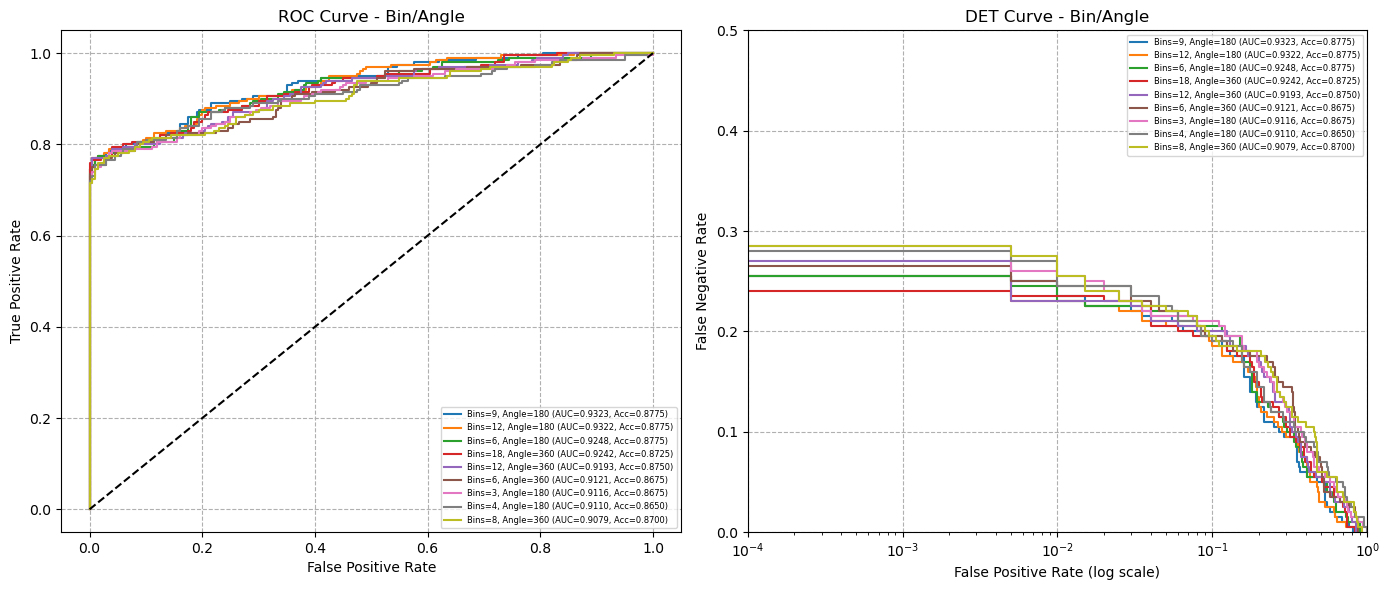

In [17]:
if results_bin_angle:
    fig, ax_roc, ax_det, ablation_results = plot_roc_det_curves(
        results_bin_angle, 
        title_prefix="Bin/Angle",
        param_format=lambda params, auc, accuracy: f"Bins={params['num_bins']}, Angle={params['angle']} (AUC={auc:.4f}, Acc={accuracy:.4f})",
        ablation_type="bin_angle"
    )
    # Save the figure
    fig.savefig(OUTPUTS_DIR / "bin_angle_ablation.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot for bin/angle experiments")

In [20]:
print(ablation_results)

# Convert results to DataFrame with selected columns
summary_df = pd.DataFrame([{
    'model': r['model'],
    'accuracy': float(r['accuracy']),  # Convert numpy float to Python float
    'auc': float(r['auc'])  # Convert numpy float to Python float
} for r in ablation_results])

# Sort by AUC in descending order
summary_df = summary_df.sort_values('auc', ascending=False)

# Format numeric columns to 4 decimal places
numeric_cols = ['accuracy', 'auc']
summary_df[numeric_cols] = summary_df[numeric_cols].round(4)

# Print results in a formatted table
print("\nModel Performance Summary:")
print("-" * 50)
print(f"{'Model':<20} {'AUC':<10} {'Accuracy':<10}")
print("-" * 50)
for _, row in summary_df.iterrows():
    print(f"{row['model']:<20} {row['auc']:<10.4f} {row['accuracy']:<10.4f}")
print("-" * 50)

# Save results to CSV using basic file operations
with open(OUTPUTS_DIR / 'bin_angle_ablation_results.csv', 'w') as f:
    f.write("model,auc,accuracy\n")  # Write header
    for _, row in summary_df.iterrows():
        f.write(f"{row['model']},{row['auc']:.4f},{row['accuracy']:.4f}\n")

print(f"\nEvaluation complete! Results saved to '{OUTPUTS_DIR}/bin_angle_ablation_results.csv'")

[{'model': 'Bins9/Angle180', 'auc': np.float64(0.9322749999999999), 'accuracy': np.float64(0.8775)}, {'model': 'Bins12/Angle180', 'auc': np.float64(0.9322), 'accuracy': np.float64(0.8775)}, {'model': 'Bins6/Angle180', 'auc': np.float64(0.92485), 'accuracy': np.float64(0.8775)}, {'model': 'Bins18/Angle360', 'auc': np.float64(0.9242250000000001), 'accuracy': np.float64(0.8725)}, {'model': 'Bins12/Angle360', 'auc': np.float64(0.9193), 'accuracy': np.float64(0.875)}, {'model': 'Bins6/Angle360', 'auc': np.float64(0.912075), 'accuracy': np.float64(0.8675)}, {'model': 'Bins3/Angle180', 'auc': np.float64(0.911575), 'accuracy': np.float64(0.8675)}, {'model': 'Bins4/Angle180', 'auc': np.float64(0.9109750000000001), 'accuracy': np.float64(0.865)}, {'model': 'Bins8/Angle360', 'auc': np.float64(0.9078750000000001), 'accuracy': np.float64(0.87)}]

Model Performance Summary:
--------------------------------------------------
Model                AUC        Accuracy  
---------------------------------

#### Bins and Angle Performance Summary

The optimal configuration was found to be:

- **Number of Bins:** 9
- **Angle Range:** 180°

This configuration achieved the highest AUC score in our experiments. Notably, these parameters match the default settings.

## Discussion

To combine the best parameters from both ablation studies, we will create and test our final model:

- **4x4 cells**  
- **32x32 blocks**  
- **9 bins**  
- **Angle range of 180**

This configuration is expected to **perform the best overall** based on previous results!

### Final model performance

Let's see how the model with defualt parameters performs on the 'hard' (unperfect_200) and 'easy (perfect_200) datasets

##### Easy test set
![Final Model on perfect dataset](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c4_b32_n9_s1_180_perfect_200.png)
![Final Model on perfect dataset (misclassified)](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c4_b32_n9_s1_180_perfect_200_misclassified.png)

##### Hard test set
![Final Model on perfect dataset](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c4_b32_n9_s1_180_unperfect_200.png)
![Final Model on perfect dataset (misclassified)](./outputs/evaluate__PETA_INRIA_h250p_nh250pp_c4_b32_n9_s1_180_unperfect_200_misclassified.png)